### Detecting a Gameboy Screen

#### Algorithm overview
1. Load the query image
2. Resize the image
3. Convert the image to grayscale, blur it and find edges.
4. Use these edges to get contours.
5. Store these contours, filled, in a new image.

#### Short aside on the bilateral filter

- Averages a pixel's intensity using a weighted combination of its neighbors' intensities.
- Removes noise while preserving edges.
- May result in plateaus of pixel intensity ('stepping').

$$
    I_{\text{filtered}}(x) = \text{Constant} \cdot \sum_{x_i \in \ \Omega}I(x_i)\  f_r(\lVert I(x_i) - I(x)\rVert)\ g_s(||x_i - x||)
$$
$I$ is input image

$x$ is a vector of the coordinates of the pixel being filtered 

$x_i$ is one of the pixels in the window

$\Omega$ is the set of pixels in the window centered on $x$

$f_r$ is the kernel for smoothing differences in intensities (i.e. weighting based on the difference between pixel values 
$I(x_i)$ and $I(x)$)

$g_s$ is the kernel for smoothing differences in coordinates (i.e. for weighting the neighboring pixels by how far they are from $x$)

Both $g_s$ and $f_s$ are typically windows of Gaussian weights centered at $x$: pixels that are closer and more visually similar to the pixel being filtered are weighted more heavily.


In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np
from numpy.linalg import norm
from scipy.misc import imread

%matplotlib inline

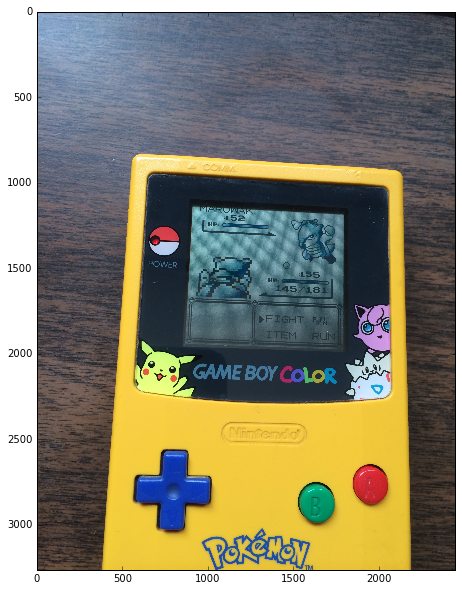

In [2]:
img = imread('./query_imgs/query_marowak.jpg')
plt.figure(figsize=(10, 10));plt.imshow(img); #plt.axis('off')

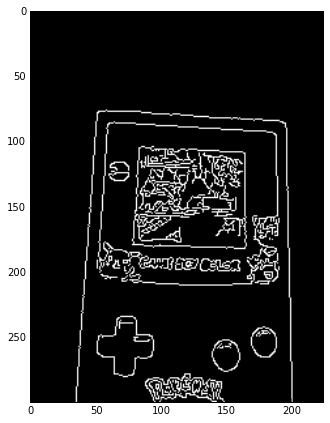

In [3]:
NEW_HEIGHT = 300
h_ratio = NEW_HEIGHT/img.shape[0]
NEW_WIDTH = h_ratio*img.shape[1]
resized_img = cv2.resize(img.copy(), dsize=(int(NEW_WIDTH), int(NEW_HEIGHT))) # Nb x, y transformatn, not row,col
gray = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
smoothed = cv2.bilateralFilter(gray, 3, 100, 100)
edges = cv2.Canny(smoothed.copy(), 30, 250)
plt.figure(figsize=(7, 7))
plt.imshow(edges, cmap='gray');

In [4]:
# find contours in the edged image, keep the larges ones,
# initialize the screen contour in a new matrix
_, cnts, _ = cv2.findContours(edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None
storage = np.zeros(edges.shape)
storage = cv2.drawContours(storage, cnts, -1, -1)

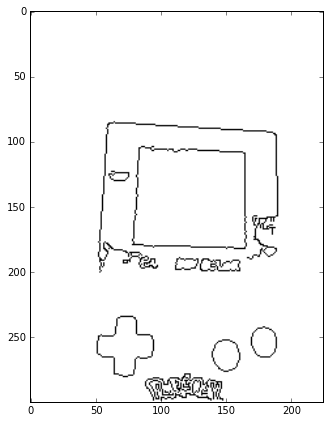

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(storage, cmap='gray');

In [6]:
for c in cnts:
    # Approximate the contour using a closed polynomial
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*perimeter, True)
    # Does the approximated contour have four points?
    if len(approx) == 4:
        screenCnt = approx
        break
        
# this method doesn't seem very robust...

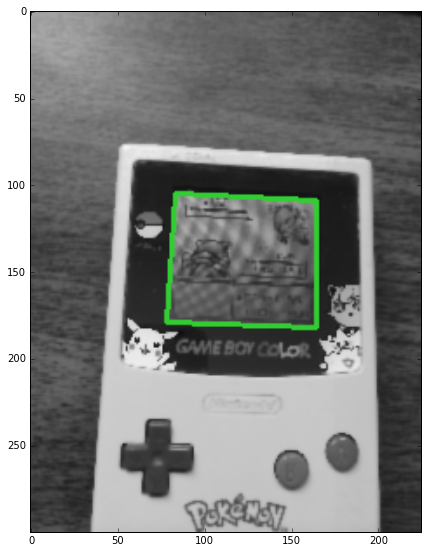

In [7]:
display = cv2.cvtColor(smoothed.copy(), cv2.COLOR_GRAY2RGB)
result = cv2.drawContours(display, [screenCnt], -1,
                          color=[50, 205, 50], thickness=2)
plt.figure(figsize=(7, 10))
plt.imshow(result);

In [8]:
# Next determine the top-left, top-right, bottom-right, bottom-left
# points so we can warm the image
# After centering:
# tl -> --
# tr -> -+
# bl -> +-
# br -> ++
# would have been faster to polar transform pts then order
pts = screenCnt.reshape(4, 2)
cpts = pts - np.mean(screenCnt.reshape(4, 2), axis=0)
rect = np.zeros([4, 2], dtype='float32') #tl, tr, br, bl
rect[0] = pts[np.argmax(-cpts[:,0] - cpts[:, 1])]
rect[1] = pts[np.argmax(-cpts[:, 0] + cpts[:, 1])]
rect[2] = pts[np.argmax(cpts[:, 0] + cpts[:, 1])]
rect[3] = pts[np.argmax(cpts[:, 0] - cpts[:, 1])]

rect /= h_ratio

In [9]:
# Screen rectangle dimensions
(tl, tr, br, bl) = rect
maxHeight = int( max(norm(tr - br), norm(tl - bl)) )
maxWidth =int( max(norm(tr - tl), norm(br - bl)) )

# Destination points in x, y coords
dst = np.array([
        [0, 0], # tl
        [0, maxHeight - 1], # tr
        [maxWidth - 1, maxHeight - 1], # br
        [maxWidth - 1, 0] # bl
    ]).astype('float32')

M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(img.copy(), M, (maxWidth, maxHeight))

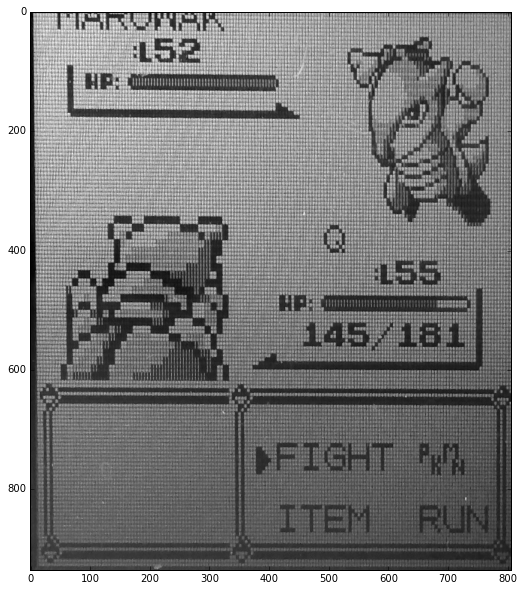

In [10]:
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
warp = exposure.rescale_intensity(warp, out_range = (0, 255))
plt.figure(figsize=(10, 10)); plt.imshow(warp, cmap='gray');

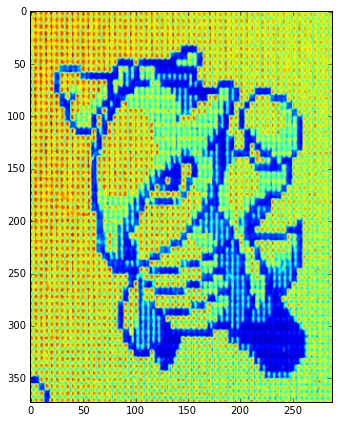

In [18]:
(h, w) = warp.shape
(dX, dY) = (int(w*0.37), int(h*0.41))
pokemon = warp[10:dY, w - dX:w - 10]
plt.figure(figsize=(7, 7)); plt.imshow(pokemon);

In [19]:
cv2.imwrite('./result_img/cropped.png', pokemon)

True